In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import math

import numpy
import pandas
import librosa
import soundfile

from matplotlib import pyplot as plt
import librosa.display

from brewaed import utils, labels, beerbubble
import brewaed



In [13]:
def load_dataset(path):
    df = pandas.read_csv(path)
    df = df.set_index('id')
    
    return df

data_dir = '../data'
files_path = os.path.join(data_dir, 'files.csv')

files = load_dataset(files_path)
files['path'] = os.path.join(data_dir, 'audio') + os.path.sep + files.filename 
files

,youtube_url,filename,path
id,,,
MN0Mg1uyznU,https://www.youtube.com/watch?v=MN0Mg1uyznU,ASMR _ Homebrewing Airlock Symphony 🍺🎼 Soothin...,../data/audio/ASMR _ Homebrewing Airlock Symph...
by0e-EkAsOE,https://www.youtube.com/watch?v=by0e-EkAsOE,One hour of apple wine airlock bubbling-by0e-E...,../data/audio/One hour of apple wine airlock b...
q2srYoC3FOo,https://www.youtube.com/watch?v=q2srYoC3FOo,Bubbling airlock on pear cider-q2srYoC3FOo.m4a,../data/audio/Bubbling airlock on pear cider-q...
p0jtxp5nWms,https://www.youtube.com/watch?v=p0jtxp5nWms,Watch an Airlock Bubbling During Mead Fermenta...,../data/audio/Watch an Airlock Bubbling During...


In [20]:
def get_id_from_labelpath(p):
    f = os.path.basename(p)
    prefix, id = f.split('.')
    assert prefix == 'labels', prefix
    return id

def load_labels(label_dir):

    paths = [ os.path.join(label_dir, f) for f in os.listdir(label_dir) ]

    ids = list(map(get_id_from_labelpath, paths))
    
    files = pandas.DataFrame({
        'path': paths,
        'id': ids,
    }).set_index('id')
    
    labels = files.groupby(by='id').apply(lambda r: brewaed.labels.read(r.path.iloc[0]))
    
    return labels

label_dir = os.path.join(data_dir, 'labels')
labels = load_labels(label_dir)
labels
#brewaed.labels.read(ll.path.iloc[0])




start        end annotation
id                                            
MN0Mg1uyznU 59   0.51200   0.896000          p
            97   0.89600   1.024000          p
            0    1.47978   1.721756          p
            98   1.79200   1.920000          p
            99   2.68800   2.816000          p
...                  ...        ...        ...
q2srYoC3FOo 9   37.37600  37.760000          p
            10  44.41600  44.672000          p
            11  51.07200  51.328000          p
            12  56.83200  56.960000          n
            13  57.60000  57.984000          p

[215 rows x 3 columns]

In [327]:
def load_features_path(path, hop_length=1024, sr=16000, start=0.0, end=1*60.0):
    feature_fft = utils.next_power_of_2(feature_hop*2)
    
    audio, sr = librosa.load(path, sr=16000, offset=start, duration=end-start)
    ff = librosa.feature.mfcc(audio, sr=sr, hop_length=feature_hop, n_fft=feature_fft, n_mfcc=13) 
    delta = librosa.feature.delta(ff, width=7, order=1)
    ff = numpy.concatenate([ff, delta], axis=0)
    ff = ff.T
    
    return ff

samplerate=16000
window_length=0.256/2
feature_hop = int(window_length*samplerate)
    
labeled_files = files.loc[labels.reset_index().id.unique()]
audio_features = labeled_files.path.apply(load_features_path, hop_length=feature_hop, sr=samplerate) 


/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [328]:
def label_frames(labels, frames, hop_length, sr=16000):
    #print(frames.shape)
    
    times = librosa.frames_to_time(numpy.arange(frames.shape[0]), hop_length=hop_length, sr=sr)
    #print(times.shape)
    
    def find_matching(times, start, end):
        s = numpy.argmin(numpy.abs(times - start))
        e = numpy.argmin(numpy.abs(times - end))
        return s, e
    
    out = numpy.empty(shape=times.shape, dtype='str')
    for start, end, lab in zip(labels.start, labels.end, labels.annotation):
        s, e = find_matching(times, start=start, end=end)
        #print(start, end, e-s)
        for i in range(s, e):
            out[i] = lab
   
    #print(labels.shape)
    #print(times[0], times[-1])
    #print(out)
    
    return out

def label_file(id, frames):
    ll = label_frames(labels.loc[id], frames, hop_length=feature_hop)
    s = pandas.Series([ll], index=[id])
    return s
    
out = []
for id, df in audio_features.groupby('id'):
    out.append(label_file(id, df[0]))
out = pandas.concat(out)
    
out
#for o in out:
#    print(o)

MN0Mg1uyznU    [, , , , p, p, p, p, , , , , p, , p, , , , , ,...
by0e-EkAsOE    [, , , , p, p, p, , , , , , , , , , , , , , , ...
p0jtxp5nWms    [, , , , , , , p, , , , , , , p, , , , , , , p...
q2srYoC3FOo    [, , , , , , , , , , , , , , , , , , , , , , ,...
dtype: object

In [329]:
def to_windows(labels, features, hop_length, sr=16000):
    
    labels = labels.rename('label')
    features = features.rename('feature')
    print(features.shape)
    
    def compute_time(f):
        times = librosa.frames_to_time(numpy.arange(f.shape[0]), hop_length=hop_length, sr=sr)
        return times
    
    times = pandas.Series([ compute_time(f) for f in features ], name='time', index=features.index)
    merged = pandas.merge(labels, features, right_index=True, left_index=True)
    merged = pandas.merge(merged, times, right_index=True, left_index=True)

    merged.index = merged.index.rename('file')
    #merged = merged.reset_index()
    
    dfs = []
    
    for idx, row in merged.iterrows():
        out = {}
        for column in merged.columns:
            out[column] = [ v for v in row[column] ]
            
        length = len(out[column])
        out['window'] = numpy.arange(length)
        out[merged.index.name] = [idx] * length

        dfs.append(pandas.DataFrame(out))
        
    df = pandas.concat(dfs)
    
    return df

windows = to_windows(out, audio_features, sr=samplerate, hop_length=feature_hop)
windows = windows.set_index(['file', 'window'])
windows

(4,)


label                                            feature  \
file        window                                                            
MN0Mg1uyznU 0             [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            1             [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            2             [-646.0416, 53.439857, -81.24144, -61.735195, ...   
            3             [-666.2483, 29.525246, -88.08321, -48.543526, ...   
            4          p  [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                  ...                                                ...   
q2srYoC3FOo 464           [-369.83347, 45.369884, 2.038496, 11.981861, -...   
            465           [-374.00208, 45.814762, 2.6812298, 15.024856, ...   
            466           [-373.18817, 47.013695, 7.4942636, 12.607885, ...   
            467           [-372.77405, 44.372395, 1.8171508, 13.644563, ...   
            468           [-376.6818, 42.069252, 5.182604, 13.706591, 0....   

                      time  
file        window          
MN0Mg1uyznU 0        0.000  
            1        0.128  
            2        0.256  
            3        0.384  
            4        0.512  
...                    ...  
q2srYoC3FOo 464     59.392  
            465     59.520  
            466     59.648  
            467     59.776  
            468     59.904  

[1876 rows x 3 columns]

In [330]:
import sklearn.model_selection
splitter = sklearn.model_selection.GroupKFold(n_splits=4)
folds = list(splitter.split(windows, groups=windows.reset_index().file))
for fold_no, (train_idx, test_idx) in enumerate(folds):
    print(fold_no, len(train_idx), len(test_idx))


train, test = windows.iloc[folds[0][0]], windows.iloc[folds[0][1]]
#train = windows.iloc[train]
#test = windows.iloc[test]



0 1407 469
1 1407 469
2 1407 469
3 1407 469


In [331]:

def build_model():
    
    import sklearn.pipeline
    import sklearn.preprocessing
    import sklearn.linear_model
    import sklearn.svm
    import sklearn.neighbors
    from sklearn.compose import make_column_transformer
    from sklearn.compose import make_column_selector

    model = sklearn.pipeline.Pipeline([
        ('scale', sklearn.preprocessing.StandardScaler()),
        ('classifier', sklearn.linear_model.LogisticRegression()),
    ])

    return model

def get_features(df):
    return numpy.array([f for f in df.feature])

m = build_model()
m.fit(get_features(train), train.label == 'p')

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', LogisticRegression())])

In [332]:
#windows = windows.set_index(['file', 'window'])
windows

label                                            feature  \
file        window                                                            
MN0Mg1uyznU 0             [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            1             [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            2             [-646.0416, 53.439857, -81.24144, -61.735195, ...   
            3             [-666.2483, 29.525246, -88.08321, -48.543526, ...   
            4          p  [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                  ...                                                ...   
q2srYoC3FOo 464           [-369.83347, 45.369884, 2.038496, 11.981861, -...   
            465           [-374.00208, 45.814762, 2.6812298, 15.024856, ...   
            466           [-373.18817, 47.013695, 7.4942636, 12.607885, ...   
            467           [-372.77405, 44.372395, 1.8171508, 13.644563, ...   
            468           [-376.6818, 42.069252, 5.182604, 13.706591, 0....   

                      time  
file        window          
MN0Mg1uyznU 0        0.000  
            1        0.128  
            2        0.256  
            3        0.384  
            4        0.512  
...                    ...  
q2srYoC3FOo 464     59.392  
            465     59.520  
            466     59.648  
            467     59.776  
            468     59.904  

[1876 rows x 3 columns]

In [352]:
def predict(model, windows):
    
    X = get_features(windows)
    Y = m.predict_proba(X)[:,1]
    
    pred = pandas.DataFrame({
      'probability': Y,
    }, index=windows.index)

    pred = pred.merge(windows, left_index=True, right_index=True)
    
    return pred

predict(m, train)
    

probability label  \
file        window                      
MN0Mg1uyznU 0          0.341936         
            1          0.341936         
            2          0.281879         
            3          0.145321         
            4          0.370960     p   
...                         ...   ...   
p0jtxp5nWms 464        0.057118         
            465        0.047831         
            466        0.039197         
            467        0.059954         
            468        0.053182         

                                                              feature    time  
file        window                                                             
MN0Mg1uyznU 0       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.000  
            1       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.128  
            2       [-646.0416, 53.439857, -81.24144, -61.735195, ...   0.256  
            3       [-666.2483, 29.525246, -88.08321, -48.543526, ...   0.384  
            4       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.512  
...                                                               ...     ...  
p0jtxp5nWms 464     [-292.80008, 125.46413, 15.257566, 25.227919, ...  59.392  
            465     [-294.45743, 122.05884, 14.210944, 22.628845, ...  59.520  
            466     [-292.944, 122.03307, 14.734277, 23.565668, -1...  59.648  
            467     [-292.2891, 124.58329, 16.456642, 24.516808, -...  59.776  
            468     [-288.5124, 126.82936, 16.229843, 22.613419, -...  59.904  

[1407 rows x 4 columns]

In [353]:
import sklearn.metrics
#Y_pred = m.predict(get_features(train))
#sklearn.metrics.f1_score(Y_pred, train.label == 'p')

sklearn.metrics.f1_score(predict(m, test).probability > 0.5, test.label == 'p')

0.8108108108108107

In [354]:
# TODO: plot PR / ROC curves

pred = predict(m, train)
pred

probability label  \
file        window                      
MN0Mg1uyznU 0          0.341936         
            1          0.341936         
            2          0.281879         
            3          0.145321         
            4          0.370960     p   
...                         ...   ...   
p0jtxp5nWms 464        0.057118         
            465        0.047831         
            466        0.039197         
            467        0.059954         
            468        0.053182         

                                                              feature    time  
file        window                                                             
MN0Mg1uyznU 0       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.000  
            1       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.128  
            2       [-646.0416, 53.439857, -81.24144, -61.735195, ...   0.256  
            3       [-666.2483, 29.525246, -88.08321, -48.543526, ...   0.384  
            4       [-754.3597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   0.512  
...                                                               ...     ...  
p0jtxp5nWms 464     [-292.80008, 125.46413, 15.257566, 25.227919, ...  59.392  
            465     [-294.45743, 122.05884, 14.210944, 22.628845, ...  59.520  
            466     [-292.944, 122.03307, 14.734277, 23.565668, -1...  59.648  
            467     [-292.2891, 124.58329, 16.456642, 24.516808, -...  59.776  
            468     [-288.5124, 126.82936, 16.229843, 22.613419, -...  59.904  

[1407 rows x 4 columns]

In [355]:
def get_events(pred):
    pred = pred.copy()
    sparse, dense = utils.mark_onoff(pred.set_index('time').probability, on_threshold=0.6, off_threshold=0.4)
    out = sparse
    
    return out

all_preds = predict(m, windows)
events = all_preds.reset_index().groupby('file').apply(get_events)
events

file               
MN0Mg1uyznU  1.536     1
             1.792     0
             2.944     1
             3.456     0
             4.224     1
                      ..
q2srYoC3FOo  37.760    0
             51.072    1
             51.328    0
             57.600    1
             57.728    0
Length: 162, dtype: int64

In [356]:
def n_events(df):
    return numpy.count_nonzero(df)
events.groupby('file').apply(n_events)

file
MN0Mg1uyznU    52
by0e-EkAsOE    22
q2srYoC3FOo     7
dtype: int64

In [357]:
labels[labels.annotation == 'p'].reset_index().groupby('id').count()

,level_1,start,end,annotation
id,,,,
MN0Mg1uyznU,96,96,96,96
by0e-EkAsOE,23,23,23,23
p0jtxp5nWms,10,10,10,10
q2srYoC3FOo,8,8,8,8


In [358]:
def ggg(df):
    df = df[df == 1].reset_index()    
    t = df['level_1']
    
    return t.diff().dropna().rename('diff')
    
p = events.groupby('file').apply(ggg)

In [359]:
def gg(df):
    return df['start'].diff().dropna().rename('diff')

h = labels[labels.annotation == 'p'].reset_index().groupby('id').apply(gg)
import seaborn


<AxesSubplot:xlabel='diff', ylabel='Count'>

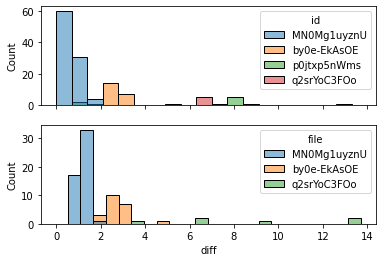

In [360]:
# TODO: make plots use one ax per file, overlay predictions with labels
fig, axs = plt.subplots(2, sharex=True)
seaborn.histplot(ax=axs[0], data=h.reset_index(), x='diff', hue='id')
seaborn.histplot(ax=axs[1], data=p.reset_index(), x='diff', hue='file')

In [365]:
# TODO: compute metrics on BPM 

def get_bpm(diffs):
    return 60.0 / diffs.median()
    
h.groupby('id').apply(get_bpm)

id
MN0Mg1uyznU    96.216911
by0e-EkAsOE    23.437500
p0jtxp5nWms     7.284639
q2srYoC3FOo     9.014423
Name: diff, dtype: float64

In [366]:
p.groupby('file').apply(get_bpm)

file
MN0Mg1uyznU    52.083333
by0e-EkAsOE    23.437500
q2srYoC3FOo     7.381890
Name: diff, dtype: float64